<a href="https://colab.research.google.com/github/KKeshav1101/C-CPP/blob/main/HateSpeechDetection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Concatenate, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df=pd.read_csv("Ethos_Dataset_Binary.csv",delimiter=";")

In [ ]:
df

,comment,isHate
0,You should know women's sports are a joke,1.0
1,You look like Sloth with deeper Down’s syndrome,1.0
2,You look like Russian and speak like Indian. B...,1.0
3,"Women deserve to be abused, I guess.",1.0
4,Women are made for making babies and cooking d...,1.0
...,...,...
993,From the midnight sun where the hot springs blow,0.0
994,Don't say I'm not your type,0.0
995,And therefore never send to know for whom the...,0.0
996,And I can't stand another day,0.0


In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"[^a-zA-Z0-9\s]","",text) #remove spl chars
  text = re.sub(r"\s+","",text).strip() #remove any extra spaces
  return text

In [ ]:
# Preprocess data
df['isHate'] = (df['isHate'] >= 0.5).astype(int)  # Binarize labels
df['cleaned_comment'] = df['comment'].apply(clean_text)

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_comment"])
sequences = tokenizer.texts_to_sequences(df["cleaned_comment"])
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['isHate'], test_size=0.2, random_state=42)

In [ ]:
input_layer = Input(shape=(max_length,))
embedding = Embedding(input_dim=5000, output_dim=128, input_length=max_length)(input_layer)

rnn_branch = SimpleRNN(64, return_sequences=True)(embedding)
rnn_branch = SimpleRNN(32)(rnn_branch)

lstm_branch = LSTM(64, return_sequences=True)(embedding)
lstm_branch = LSTM(32)(lstm_branch)

merged = Concatenate()([rnn_branch, lstm_branch])
merged = Dense(32, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output_layer = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5160 - loss: 0.6924 - val_accuracy: 0.5800 - val_loss: 0.6877
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6158 - loss: 0.6707 - val_accuracy: 0.5800 - val_loss: 0.6840
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7549 - loss: 0.6009 - val_accuracy: 0.5050 - val_loss: 0.6961
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9965 - loss: 0.2784 - val_accuracy: 0.5000 - val_loss: 0.8357
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0338 - val_accuracy: 0.4700 - val_loss: 1.0341
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.4650 - val_loss: 1.1281
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.4700 - val_loss: 1.1952
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.4750 - v

In [ ]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.485
F1 Score: 0.44324324324324327
Confusion Matrix:
[[56 60]
 [43 41]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       116
           1       0.41      0.49      0.44        84

    accuracy                           0.48       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.50      0.48      0.49       200



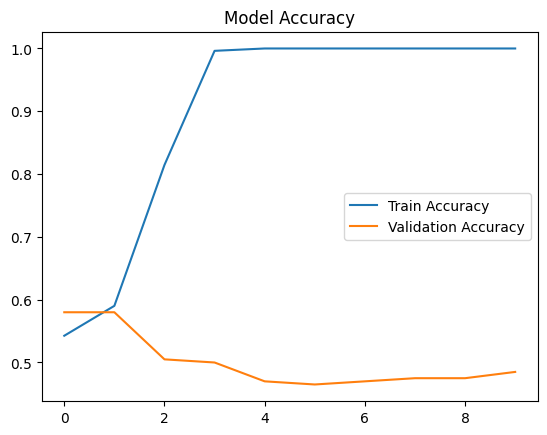

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

Clearly overfitting, so lets try some model changes(GRU, LSTM) and cross validation

In [ ]:
# Stratified K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list, f1_list = [], []

In [ ]:
for train_idx, val_idx in kfold.split(padded_sequences, df['isHate']):
    X_train, X_val = padded_sequences[train_idx], padded_sequences[val_idx]
    y_train, y_val = df['isHate'].iloc[train_idx], df['isHate'].iloc[val_idx]

    # Define model
    input_layer = Input(shape=(max_length,))
    embedding = Embedding(input_dim=10000, output_dim=128, input_length=max_length)(input_layer)
    embedding = SpatialDropout1D(0.3)(embedding)

    lstm_branch = LSTM(64, return_sequences=True, recurrent_dropout=0.3)(embedding)
    lstm_branch = LSTM(32)(lstm_branch)

    gru_branch = GRU(64, return_sequences=True, recurrent_dropout=0.3)(embedding)
    gru_branch = GRU(32)(gru_branch)

    merged = Concatenate()([lstm_branch, gru_branch])
    merged = Dense(64, activation='relu')(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(0.5)(merged)
    output_layer = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Predictions
    y_pred = (model.predict(X_val) > 0.5).astype(int)

    # Evaluation
    accuracy_list.append(accuracy_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.5379 - loss: 0.6903 - val_accuracy: 0.5650 - val_loss: 0.6875
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6891 - loss: 0.6358 - val_accuracy: 0.5650 - val_loss: 0.6847
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9196 - loss: 0.3731 - val_accuracy: 0.5650 - val_loss: 0.6798
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9944 - loss: 0.0571 - val_accuracy: 0.5700 - val_loss: 0.6790
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9974 - loss: 0.0178 - val_accuracy: 0.5700 - val_loss: 0.6777
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9979 - loss: 0.0156 - val_accuracy: 0.5900 - val_loss: 0.6744
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.5750 - val_loss: 0.6782
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.5850 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5101 - loss: 0.6971 - val_accuracy: 0.5650 - val_loss: 0.6878
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6381 - loss: 0.6650 - val_accuracy: 0.5650 - val_loss: 0.6858
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8429 - loss: 0.5160 - val_accuracy: 0.5650 - val_loss: 0.6846
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9839 - loss: 0.1362 - val_accuracy: 0.5750 - val_loss: 0.6859
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9980 - loss: 0.0368 - val_accuracy: 0.5600 - val_loss: 0.6884
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9996 - loss: 0.0162 - val_accuracy: 0.5650 - val_loss: 0.7008


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.5192 - loss: 0.6928 - val_accuracy: 0.5650 - val_loss: 0.6865
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6877 - loss: 0.6255 - val_accuracy: 0.5650 - val_loss: 0.6842
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8893 - loss: 0.3845 - val_accuracy: 0.5650 - val_loss: 0.6834
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9909 - loss: 0.0626 - val_accuracy: 0.5650 - val_loss: 0.6935
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9947 - loss: 0.0191 - val_accuracy: 0.5650 - val_loss: 0.6951
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9953 - loss: 0.0121 - val_accuracy: 0.5650 - val_loss: 0.6978


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5203 - loss: 0.6986 - val_accuracy: 0.5678 - val_loss: 0.6876
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6916 - loss: 0.6418 - val_accuracy: 0.5678 - val_loss: 0.6841
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8525 - loss: 0.4438 - val_accuracy: 0.5678 - val_loss: 0.6815
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9892 - loss: 0.0947 - val_accuracy: 0.5729 - val_loss: 0.6807
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9981 - loss: 0.0236 - val_accuracy: 0.5678 - val_loss: 0.6821
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.5578 - val_loss: 0.6859
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9982 - loss: 0.0100 - val_accuracy: 0.5628 - val_loss: 0.6858
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.5568 - loss: 0.6872 - val_accuracy: 0.5678 - val_loss: 0.6867
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6591 - loss: 0.6423 - val_accuracy: 0.5678 - val_loss: 0.6846
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9085 - loss: 0.3938 - val_accuracy: 0.5678 - val_loss: 0.6832
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9729 - loss: 0.0930 - val_accuracy: 0.5829 - val_loss: 0.6843
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9943 - loss: 0.0279 - val_accuracy: 0.5829 - val_loss: 0.6895
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9988 - loss: 0.0122 - val_accuracy: 0.5829 - val_loss: 0.6911
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


In [ ]:
# Final Evaluation Metrics
print("Average Accuracy:", np.mean(accuracy_list))
print("Average F1 Score:", np.mean(f1_list))

Average Accuracy: 0.572140703517588
Average F1 Score: 0.06256019261637238


In [ ]:
# Predictions on Test Data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['isHate'], test_size=0.2, random_state=42)
y_pred_test = (model.predict(X_test) > 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Final Test F1 Score:", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Final Test Accuracy: 0.59
Final Test F1 Score: 0.046511627906976744
Confusion Matrix:
[[116   0]
 [ 82   2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       116
           1       1.00      0.02      0.05        84

    accuracy                           0.59       200
   macro avg       0.79      0.51      0.39       200
weighted avg       0.76      0.59      0.45       200



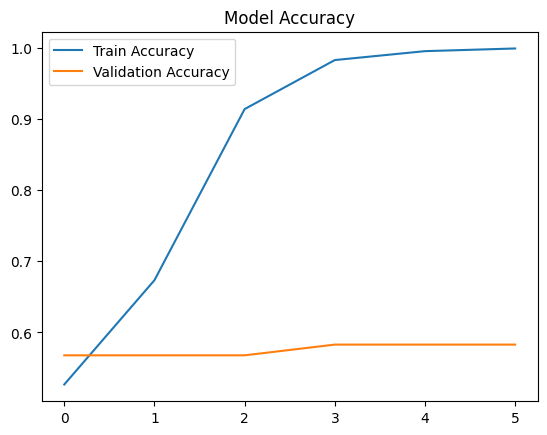

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()